In [19]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d
import copy
import geopandas as gp

cwd = os.getcwd()
par = os.path.dirname(cwd)
sys.path.append(par)

# local functions
import diff_nmf
import grid_search
import data_generator
import nmf
from diff_nmf import diff_nmf
from grid_search import gridSearcher
from data_generator import *
from nmf import nmf
from graph_utility import graph_util

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**In this experiment we use real COVID-19 case data for a collection of contiguous (or at least close in distance) European countries (found in covid_dataset/us_county/) to see if Diffusion-NMF might recover trends not seen by NMF.** European countries are particularly nice to study because they have good data, there are many countries which are very close to one another (if not bordering), and because many have different covid policies/regulations. 

### Graph Preliminary

In [4]:
sns.set_palette("Set2")
plt.rcParams['font.family'] = 'Linux Libertine O'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 1

# custom hex list for colormap
h_list = ["ffb950","ffad33","ff931f","ff7e33","fa5e1f","ec3f13","b81702","a50104","8e0103","7a0103"]
# get custom features from graph_util
graph_tool = graph_util()
linestyles_dict = graph_tool.linestyles()
my_pal = graph_tool.custom_map(h_list)

## Data

In [5]:
# importing
dataset = pd.read_csv(os.path.join(par, "covid_dataset/country/dataset.csv"), index_col = 0).astype(np.float64)
laplacian = pd.read_csv(os.path.join(par, "covid_dataset/country/laplacian.csv"), index_col = 0)
population = pd.read_csv(os.path.join(par, "covid_dataset/country/population.csv"), index_col = 0)
population.loc[:, 'population_estimate'] = population.loc[:, 'population_estimate'].astype(np.float64)

# json file with geographic info for each state -- required for graphing
europe_map = os.path.join(par, 'covid_dataset/country/europe_geography.json')

In [10]:
# need to filter data so that I'm only considering a pre-made selection of european countries. We specifically chose countries from europe because 
# there are so many which are close in proximity (if not contiguous)

eu_countries = ['RUS', 'UKR', 'FRA', 'ESP', 'SWE', 'NOR', 'KAZ', 'DEU', 'FIN', 'POL', 'ITA', 'GBR', 'ROU', 'BLR', 'GRC', 'BGR', 'HUN', 'PRT', 'AUT', 
                'CZE', 'SRB', 'IRL', 'LTU', 'LVA', 'HRV', 'BIH', 'SVK', 'EST', 'DNK', 'CHE', 'NLD', 'MDA', 'BEL', 'ALB', 'MKD', 'TUR', 'SVN', 'MNE', 'KOS',
                'AZE', 'LUX', 'GEO', 'AND', 'MLT', 'LIE', 'SMR', 'MCO', 'CYP', 'ARM']

dataset = dataset.loc[:,eu_countries]
laplacian = laplacian.loc[eu_countries, eu_countries]
population = population.loc[population.country.isin(eu_countries)]

**Data Cleaning/Preparation:** We perform a location-wise normalization of data with the help of separate population data. Specifically each location's set of case counts is divided the location's estimated population. This ensures that both densely and non-densely populated areas are given (to the best of our ability) equal representation within the data. 

We also use an isotonic regression on each of the columns of the data to fix any inconsistencies. Sometimes it happens that a location might falsely report a decline in cumulative cases (which shouldn't be possible given that cases can't erase themselves). We have not investigated reasons for why this may happen, but have taken precaution to ensure that these be corrected so as not to affect the output of our algorithm. More specifically, for each location an isotonic regression fits a new line (not necessarily linear or continuous) which not only matches the data points which are already increasing, but also makes sure to correct any decreasing data points, giving them new values that enforce the strictly increasing constraint. Any location whose data does not contain errors is not changed. 

In [16]:
for col in dataset.columns:
    dataset.loc[:,col] /= population.loc[population.country == col].population_estimate.item()
    
# perfrom isotonic regression to fix inconsitencies:
dataset = iso_regression(dataset)

## Grid Search

**Given the computational cost of a grid search I have chosen to exclude it from the notebook. What is shown is a pre-saved image of the results. I have tried to make the process simple and easy to follow by including the grid_search.py file in the repository.** To find the best set of parameters for which diffusion-nmf performs best we chose to try a range of different rank and beta (spread parameter) combinations. We choose final values by analyzing the trends shown in the graph and finding parameter combinations that give small relative error. 

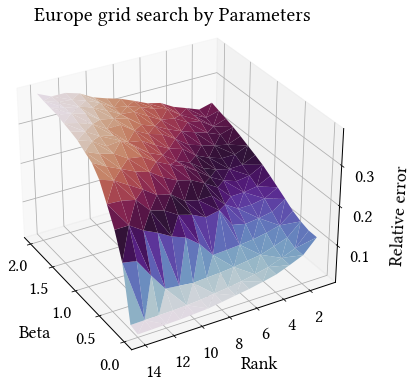

In [18]:
grid = pd.read_csv(os.path.join(par, "covid_dataset/country/grid_search_results/europe_rank_beta.csv"))
fig = plt.figure(figsize = (10,6))
ax = fig.gca(projection='3d')
ax.plot_trisurf(grid['beta'], grid['rank'], grid['relative error'], cmap=plt.cm.twilight, linewidth=0.2)
plt.xlabel("beta")
plt.ylabel("rank")
ax.set_zlabel("relative error")
ax.view_init(30,150)

ax.xaxis.set_tick_params(which='major', size=10, width=1, direction='out')
ax.xaxis.set_tick_params(which='minor', size=2, width=1, direction='out')
ax.yaxis.set_tick_params(which='major', size=10, width=1, direction='out')
ax.yaxis.set_tick_params(which='minor', size=2, width=1, direction='out')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.5))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(2))

ax.set_xlabel("Beta", fontsize = 18, labelpad = 13)
ax.set_ylabel("Rank", fontsize = 18, labelpad = 10)
ax.set_zlabel("Relative error", fontsize = 18, labelpad = 10)
ax.set_title("Europe grid search by Parameters", fontsize = 20)
ax.view_init(30,150)
ax.dist = 9

In the paper and in the rest of this notebook we will present results for the parameter combination of rank = 4 and Beta = 0.5. Unfortunately this is one example for which it is difficult to discern what the correct paramter choice may be. We chose a rank of 4 because this gives us enough waves to be descriptive of the pandemic and because with more than 4 waves error rises rapidly (especially seen with larger beta values). For beta we simply chose 0.5 on the intuition that error does drop rapidly as it approaches 0. In fact, right around the value of 0 the error seems to be minimized. However, we must keep in mind that when beta = 0, the results we see are simply the same results from standard NMF. To constrain our algorithm to find solutions which correspond to a diffusion process does mean taking on more error and is only justified by our hypothesis that waves do spread from location to location in a diffusion-like process. For this reason we chose to move further from 0 to 0.5 in order to make sure our algorithm can do it's magic.

## Results

In [20]:
# prepare parameters
rank = 4
beta = 0.5
K = np.linalg.inv(np.identity(len(laplacian)) + beta * laplacian.to_numpy())

# diffusion nmf (takes a few minutes or so)
dNMF = diff_nmf(n_components = rank, kernel = K, n_iter = 200000  , tol = 1e-10)
X,V = dNMF.fit_transform(dataset)

In [21]:
# regular nmf for comparison
nmfer = nmf(rank, n_iter = 200000, tol = 1e-10)
W,H = nmfer.fit_transform(dataset)

Max iterations reached, increase to converge on given tolerance


In [24]:
#rescaling
X,V = rescale(X,V)
X = pd.DataFrame(X, index = dataset.index)
V = pd.DataFrame(V, columns = dataset.columns)

W,H = rescale(W,H)
W = pd.DataFrame(W, index = dataset.index)
H = pd.DataFrame(H, columns = dataset.columns)

**Note that for side by side comparison later you'd need to re order the waves here so that similar waves are compared together.** For best comparison please see the figures included in our paper, but feel free to use whats given below to re-order it for yourself. Simply change the order of waves by changing the re-order list below. I wish I had a nice method to automate this, but haven't found one yet. My tactic is to order them by time-wise appearance of waves. The very first wave to see some sort of peak (even if its very small) is wave 0, next is wave 1, etc. Note that the outputs from NMF and DNMF must be ordered separately.

In [27]:
# RE-order for better presentation
X.columns = ["Wave " + str(i) for i in range(rank)]
W.columns = ["Wave " + str(i) for i in range(rank)]
V.index = ["Wave " + str(i) for i in range(rank)]
H.index = ["Wave " + str(i) for i in range(rank)]

standard = X.columns
reorder = ['Wave 3', 'Wave 1', 'Wave 2', 'Wave 0']
X = X[reorder]
X.columns = standard
V = V.reindex(reorder)
V.index = standard 

# RE-order for better presentation
standard = [0,1,2,3]
reorder = ['Wave 2', 'Wave 1', 'Wave 0', 'Wave 3']
W = W[reorder]
W.columns = standard
H = H.reindex(reorder)
H.index = standard 

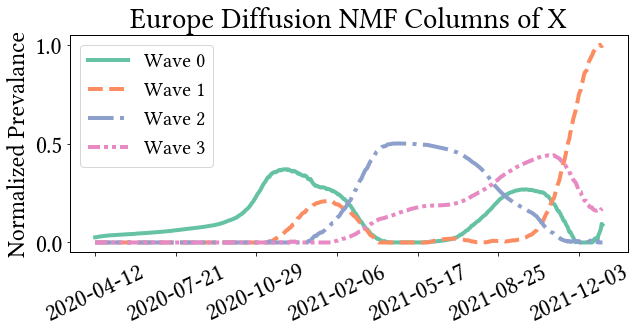

In [28]:
plt.rcParams["font.size"] = 24
plt.rcParams["legend.fontsize"] = 20
X.iloc[:,:-1].plot(figsize = (10,4), linewidth = 4, style = ['-', '--', '-.', ':'])
plt.plot(X.iloc[:,-1], linewidth = 4, linestyle = linestyles_dict["densely dashdotdotted"], label = "Wave 3")
plt.legend()
plt.xticks(rotation = 25)
plt.ylabel("Normalized Prevalance")
plt.title("Europe Diffusion NMF Columns of X")
#plt.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/state_diffX.pdf',  bbox_inches = "tight")
plt.show()

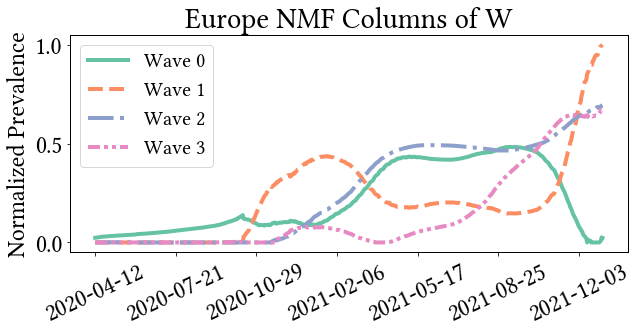

In [29]:
plt.rcParams["font.size"] = 24
W.iloc[:,:-1].plot(figsize = (10,4), linewidth = 4, style = ['-', '--', '-.', ':'])
plt.plot(W.iloc[:,-1], linewidth = 4, linestyle = linestyles_dict["densely dashdotdotted"], label = "Wave 3")
plt.legend()

plt.xticks(rotation = 25)
plt.ylabel("Normalized Prevalence")
plt.title("Europe NMF Columns of W")
#plt.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper2/figures/state_nmfX.pdf',  bbox_inches = "tight")
plt.show()

The two figures above show that both NMF and D-NMF capture similar waves with only slight differences. It might be noted that peaks within curves of the D-NMF solution are a bit sharper, but the real advantage to D-NMF comes from analyzing the V matrix (shown row-by-row in map form in the figures below). 

**Change the row_num variable in the following cells to change which wave you view**

In [38]:
eurMap = gp.read_file(europe_map)

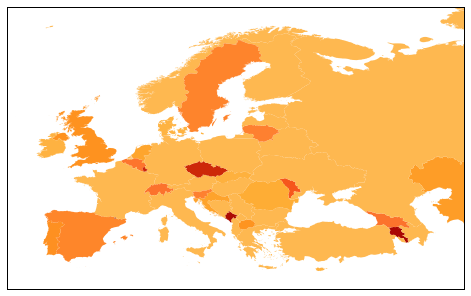

In [34]:
row_num = 0

val_col1 = []
for i in eurMap["ISO_A3"]:
    try:
        val_col1.append(V.loc["Wave " + str(row_num),i])
    except:
        val_col1.append(np.nan)


eurMap['val1'] = val_col1


fig,ax = plt.subplots(1,1, constrained_layout=True, figsize = (8,4))

eurMap.plot(column='val1',legend=False, ax = ax, cmap=my_pal, legend_kwds={'shrink': 0.90, 'aspect': 40})
ax.set_xlim(-15, 55)
ax.set_ylim(32, 74)
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)

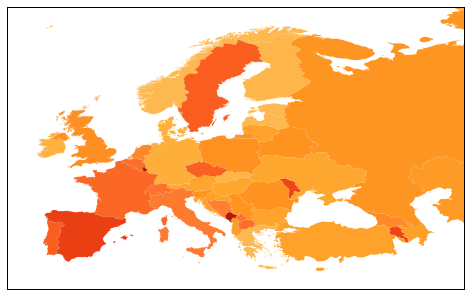

In [35]:
row_num = 0

val_col1 = []
for i in eurMap["ISO_A3"]:
    try:
        val_col1.append(H.loc["Wave " + str(row_num),i])
    except:
        val_col1.append(np.nan)


eurMap['val1'] = val_col1


fig,ax = plt.subplots(1,1, constrained_layout=True, figsize = (8,4))

eurMap.plot(column='val1',legend=False, ax = ax, cmap=my_pal, legend_kwds={'shrink': 0.90, 'aspect': 40})
ax.set_xlim(-15, 55)
ax.set_ylim(32, 74)
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)

Changing the row_num parameter in the two cells above allows you to view maps which correspond to other waves or rows of V/H. For most it is clear that the D-NMF solution does a better job of highlighting origin points or centers of diffusion within the data. Whereas NMF solutions have coefficients which are very similar to each other, there are sharper contrasts between certain counties and their neighbors in the D-NMF solutions. If our hypotheses are correct, these states colored in darker red are locations from which their respective wave either originated or had a larger than normal effect. 

### Error Checking

The following was run through the process of another grid search (Again full search not included here because of computational cost). However this time the beta was kept at a constant value of 1. This was done so that a comparison with the error seen with NMF would be allowed. Seen is the respective relative error seen by both NMF and D-NMF as the rank parameter changes. What's clear is that NMF is consistently better in error, but this is to be expected. Our algorithm is a constraint to the NMF problem with may increase error but benefits from increased interpratability. 

In [36]:
europe_diff_error = pd.read_csv(os.path.join(par, "covid_dataset/country/grid_search_results/europe_diff_error.csv"))
europe_nmf_error = pd.read_csv(os.path.join(par, "covid_dataset/country/grid_search_results/europe_nmf_error.csv"))

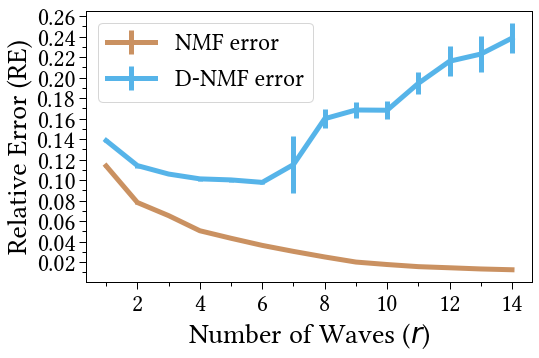

In [37]:
c_pal = sns.color_palette("colorblind", 10)
plt.rcParams['legend.fontsize'] = 24
ranks = list(range(1,15))
fig, ax = plt.subplots(1,1, figsize = (8,5))
ax.xaxis.set_tick_params(which='major', size=7, width=1, direction='out')
ax.xaxis.set_tick_params(which='minor', size=4, width=1, direction='out')
ax.yaxis.set_tick_params(which='major', size=7, width=1, direction='out')
ax.yaxis.set_tick_params(which='minor', size=4, width=1, direction='out')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.02))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))

ax.errorbar(ranks, europe_nmf_error["relative error"], europe_nmf_error["std error"], label = "NMF error", linewidth = 5, color = c_pal[5])
ax.errorbar(ranks, europe_diff_error["relative error"], europe_diff_error["std error"], label = "D-NMF error", linewidth = 5, color = c_pal[9])

ax.set_xlabel(r"Number of Waves ($r$)", fontsize = 28)
ax.set_ylabel("Relative Error (RE)", fontsize = 28)
plt.legend()
#plt.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/state_error.pdf', bbox_inches = "tight")